In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import keras.backend as K
import plotly.express as px
from sklearn.metrics import classification_report
from tensorflow.keras.applications import xception

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### EDA

In [3]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 30

In [4]:
# Reading data
files = tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/COVID 19/*")
files.extend(tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/NORMAL/*"))
files.extend(tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/Viral Pneumonia/*"))

In [5]:
# obtaining split sets
train_files, test_files = train_test_split(files, test_size=0.1, random_state=42)

In [6]:
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

In [7]:
normal_count = len([file for file in files if 'NORMAL' in file])
covid_count = len([file for file in files if 'COVID' in file[-20:]])
pneumonia_count = len([file for file in files if 'Viral Pneumonia' in file])

In [8]:
class_distribution = pd.DataFrame({'class':['normal','viral pneumonia','covid'],
                                   'count':[normal_count, pneumonia_count, covid_count]})

In [9]:
fig = px.bar(class_distribution, x="class", y="count", title="Distribution of images")
fig.update_layout(width=800, height=300)
fig.show()

In [10]:
train_normal_count = len([file for file in train_files if 'NORMAL' in file])
train_covid_count = len([file for file in train_files if 'COVID 19' in file])
train_pneumonia_count = len([file for file in train_files if 'Viral Pneumonia' in file])

print(train_normal_count, train_covid_count, train_pneumonia_count)

970 871 963


In [11]:
# converting to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

In [12]:
TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()
VAL_SIZE = tf.data.experimental.cardinality(val_dataset).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_dataset).numpy()

In [13]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(2804, 702, 390)

In [14]:
'''
takes a file path as input
returns the target value for the given image
'''
def get_targets(file):
    split = tf.strings.split(file, os.path.sep)
    if split[-2] == 'COVID 19':
        return 0
    elif split[-2] == 'Viral Pneumonia':
        return 2
    else: return 1

In [15]:
'''
input: file path of image
returns a processed image along with the target
'''
def preprocess_img(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, target

In [16]:
# preprocessing datasets
train_data = train_dataset.map(preprocess_img)
val_data = val_dataset.map(preprocess_img)
test_data = test_dataset.map(preprocess_img)

In [17]:
# batching test set
test_data = test_data.batch(BATCH_SIZE)

In [18]:
'''
input: number of image samples needed and a tf dataset of images
returns: normal, covid, and pneumonia images as a numpy array
'''
def images_in_class_buckets(image_count, data):
    train_normal = []
    train_pneumonia = []
    train_covid = []

    for img, target in train_data.take(image_count):
        if target == 0:
            train_covid.append(img.numpy())
        elif target == 1:
            train_pneumonia.append(img.numpy())
        else: train_normal.append(img.numpy())
    
    train_normal = np.array(train_normal)
    train_covid = np.array(train_covid)
    train_pneumonia = np.array(train_pneumonia)
    
    return (train_normal, train_covid, train_pneumonia)

In [19]:
train_normal, train_covid, train_pneumonia = images_in_class_buckets(300, train_data)

KeyboardInterrupt: ignored

#### Mean pixels for images

In [46]:
'''
input: set of images
returns a mean image (pixel mean)
'''
def get_mean_img(images):
    image_mean = np.mean(images, axis=0)
    return image_mean

In [47]:
mean_normal = get_mean_img(train_normal)
mean_covid = get_mean_img(train_covid)
mean_pneumonia = get_mean_img(train_pneumonia)

In [48]:
def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
show_image(mean_normal, 'NORMAL')
show_image(mean_pneumonia, 'PNEUMONIA')
show_image(mean_covid, 'COVID')


#### Variability in pixels

In [50]:
'''
input: set of images
returns an image that indicates the standard deviation
across all images
'''
def get_stdev_img(images):
    image_dev = np.std(images, axis=0)
    return image_dev

In [51]:
dev_normal = get_stdev_img(train_normal)
dev_covid = get_stdev_img(train_covid)
dev_pneumonia = get_stdev_img(train_pneumonia)

In [ ]:
show_image(dev_normal, 'NORMAL')
show_image(dev_pneumonia, 'PNEUMONIA')
show_image(dev_covid, 'COVID')

#### Batching and shuffling

In [20]:
'''
input: image dataset
returns: shuffled, batched and prefetched set of images
return type: PrefetchDataset
'''
def preprocessing(dataset, buffer_size=650):
    dataset = dataset.shuffle(buffer_size=buffer_size).repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [21]:
train_set = preprocessing(train_data)
val_set = preprocessing(val_data)

In [22]:
train_set

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
sample_images, sample_targets = next(iter(train_set))

In [57]:
def visualize_samples(images, targets):
    plt.figure(figsize=(12,8))
    for n in range(16):
        sub = plt.subplot(4,4,n+1)
        plt.imshow(images[n])
        if targets[n] == 0:
            plt.title("COVID")
        elif targets[n] == 1:
            plt.title("PNEUMONIA")
        else:plt.title("NORMAL")
        plt.axis("off")

In [1]:
visualize_samples(sample_images.numpy(), sample_targets.numpy())

NameError: ignored

### Modeling

In [28]:
'''
convolution block with 2 separable convolution layers,
batch normalization, and max pooling
'''
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [29]:
'''
dense block with batch norm and dropout regularization
'''
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [30]:
'''
returns a sequential base model
'''
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        conv_block(256),
        tf.keras.layers.Dropout(rate=0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        
        dense_block(128, 0.5),
        dense_block(64, 0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    return model

In [31]:
# build and compile model
model = build_model()
optim = tf.keras.optimizers.Adam(learning_rate=0.0006)

model.compile(
    optimizer= optim,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [32]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
sequential (Sequential)      (None, 56, 56, 128)       27072     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 256)       103296    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 256)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 14, 14, 256)       137216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)      

In [33]:
# callbacks for training
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/Shareddrives/Covid Recognition Practicum/models/base_model.h5",save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10, mode='min', min_lr=1E-5)

In [ ]:
# model training
history = model.fit(
    train_set,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_set,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint]
)

Train for 43 steps, validate for 10 steps
Epoch 1/30
43/43 [==============================] - 61s 1s/step - loss: 0.4691 - accuracy: 0.8376 - val_loss: 1.0978 - val_accuracy: 0.3672
Epoch 2/30
43/43 [==============================] - 50s 1s/step - loss: 0.3339 - accuracy: 0.8805 - val_loss: 1.0946 - val_accuracy: 0.3656
Epoch 3/30
43/43 [==============================] - 50s 1s/step - loss: 0.2871 - accuracy: 0.8997 - val_loss: 1.1458 - val_accuracy: 0.2859
Epoch 4/30
43/43 [==============================] - 49s 1s/step - loss: 0.2421 - accuracy: 0.9135 - val_loss: 1.2320 - val_accuracy: 0.2906
Epoch 5/30
43/43 [==============================] - 49s 1s/step - loss: 0.1885 - accuracy: 0.9295 - val_loss: 1.4561 - val_accuracy: 0.2937
Epoch 6/30
43/43 [==============================] - 50s 1s/step - loss: 0.1736 - accuracy: 0.9459 - val_loss: 1.6024 - val_accuracy: 0.2859
Epoch 7/30
43/43 [==============================] - 49s 1s/step - loss: 0.1782 - accuracy: 0.9397 - val_loss: 1.9031 -

### Evaluation

In [ ]:
# evaluate model on test data
model.evaluate(test_data)

7/7 [==============================] - 4s 577ms/step - loss: 0.0465 - accuracy: 0.9846


[0.04648796036573393, 0.9845758]

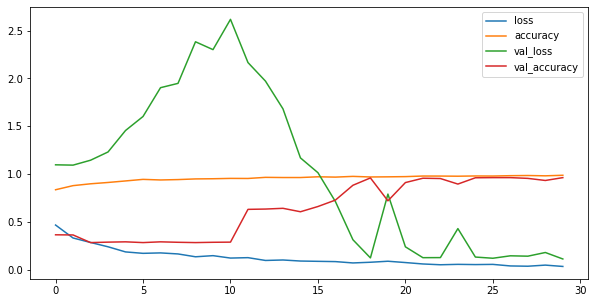

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.title('Learning curves for base model')
plt.show()

In [ ]:
# unbatch test data
test_x = test_data.take(5000).map(lambda X,y: X)
test_y = test_data.take(5000).map(lambda X,y: y)
test_y = test_y.apply(tf.data.experimental.unbatch())

In [ ]:
# obtaining predictions
pred = model.predict(test_x)
pred_class = np.argmax(pred, axis=1)
pred_class = pred_class.tolist()

In [ ]:
# obtaining ground truth targets
y_true = []
for i in test_y.take(5000):
    y_true.append(i.numpy())

In [ ]:
target_names = ['Covid', 'Normal', 'Pneumonia']

In [ ]:
print(classification_report(y_true=y_true, y_pred=pred_class, target_names=target_names))

              precision    recall  f1-score   support

       Covid       1.00      0.99      1.00       124
      Normal       0.99      0.98      0.98       143
   Pneumonia       0.97      0.98      0.98       122

    accuracy                           0.98       389
   macro avg       0.98      0.98      0.98       389
weighted avg       0.98      0.98      0.98       389



### Model selection

#### Transfer learning

In [34]:
def preprocess_img_xception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = xception.preprocess_input(img)
    
    return img, target

In [35]:
train_data_tl = train_dataset.map(preprocess_img_xception)
val_data_tl = val_dataset.map(preprocess_img_xception)
test_data_tl = test_dataset.map(preprocess_img_xception)

In [36]:
train_set_tl = preprocessing(train_data_tl)
val_set_tl = preprocessing(val_data_tl)

In [37]:
test_set_tl = test_data_tl.batch(BATCH_SIZE)

In [38]:
deep_model = xception.Xception(weights="imagenet", include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [39]:
deep_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [40]:
avg = tf.keras.layers.GlobalAveragePooling2D()(deep_model.output)

In [41]:
out = tf.keras.layers.Dense(3, activation='softmax')(avg)

In [42]:
model2 = tf.keras.Model(inputs=deep_model.input, outputs=out)

In [43]:
for layer in deep_model.layers:
    layer.trainable = False

In [44]:
optim2 = tf.keras.optimizers.Adam(learning_rate=0.2)
model2.compile(
    optimizer= optim2,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [45]:
checkpoint2 = tf.keras.callbacks.ModelCheckpoint("/content/drive/Shareddrives/Covid Recognition Practicum/models/covid_model_deep.h5",save_best_only=True)

history2 = model2.fit(
    train_set_tl,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = 8,
    validation_data = val_set_tl,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint2]
)

Epoch 1/8
 4/43 [=>............................] - ETA: 11:05 - loss: 2.9455 - accuracy: 0.3805

KeyboardInterrupt: ignored

In [ ]:
for layer in deep_model.layers:
    layer.trainable = True

In [ ]:
optim3 = tf.keras.optimizers.Adam(learning_rate=0.0006)
model2.compile(
    optimizer= optim3,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [ ]:
history2 = model2.fit(
    train_set_tl,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_set_tl,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint2]
)

Train for 43 steps, validate for 10 steps
Epoch 1/30
 1/43 [..............................] - ETA: 15:54WARNING:tensorflow:Can save best model only with val_loss available, skipping.


ResourceExhaustedError:  OOM when allocating tensor with shape[728,256,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block4_sepconv1/separable_conv2d (defined at <ipython-input-34-42e74024f111>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_21893]

Function call stack:
distributed_function
